# 勾配降下法 (Gradient Descent)

ニューラルネットワークのような機械学習モデルにおいて，学習可能パラメータをどうやって最適なものにすればいいでしょうか？最終的に損失関数の値を求めるまでの計算が全て微分可能である場合は，__勾配降下法 （Gradient Descent）__ がよく用いられます．ここでは簡単な勾配降下法を解説します．

In [1]:
import math 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib_fontja
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML,display

あるニ次関数$f(x)$ が最も小さい値をとる$x_*$が知りたい場合，どうすればいいでしょうか．例えば$f(x)$ 上のランダムな初期位置 $x_0$ から移動を始めて，$f(x)$の最も小さい値をとる場所へ徐々に$x$を修正していくことを考えましょう．

$f(x)$ の$x_0$での傾きを確認します．傾きの逆方向に移動すると，より$f(x)$の値が小さい方向へ移動できるはずです．これを繰り返すことで，最小値をとる$x_*$が見つけられるかもしれません．

In [196]:
def make_animation_of_gd():
    # 関数 f(x) = x^2
    def f(x):
        return x**2

    # 接線の傾き（導関数）を求める
    def tangent_slope(x):
        return 2 * x

    # 接線の式
    def tangent_line(x, x0):
        slope = tangent_slope(x0)
        return slope * (x - x0) + f(x0)

    # 数値微分
    def _numerical_diff(f, x, h = 1e-4):
        return (f(x+h) - f(x-h)) / (2*h)

    # 数値微分で求めた接線の式
    def numerical_tangent_line(x,f, x0):
        slope = _numerical_diff(f, x0, )
        return slope * (x - x0) + f(x0)

    ####################################
    # グラフの範囲
    x_lim=10
    x_vals = np.linspace(-x_lim, x_lim, 1000)
    #x0 = 3  # x=3での接線を求める
    #fig, ax = plt.subplots()
    fig, ax = plt.subplots()
    fig.suptitle(f'$f(x)=x^2$の傾き')
    ims = []
    for x0 in np.linspace(0,10,100)[::-1]:
        # グラフの描画
        ax.set_xlim(-x_lim,x_lim)
        ax.grid(True)
        ax.set_xlabel('$x$')
        ax.set_ylabel('$x^2$')
        p2, = ax.plot(x_vals, f(x_vals), label='f(x) = $x^2$', color="green")
        p0, = ax.plot(x0, f(x0), "o", label='接点')
        p1, = ax.plot(x_vals, numerical_tangent_line(x_vals, f, x0), label=f'数値微分による接線 at $x={x0}$', linestyle='-', color="orange")
        ims.append([p0, p1, p2])
        plt.close()

    ani = animation.ArtistAnimation(fig, ims, interval=100)
    ####################################
    # グラフの範囲
    x_lim=5
    x_vals = np.linspace(0.1, x_lim, 1000)
    #x0 = 3  # x=3での接線を求める
    #fig, ax = plt.subplots()
    fig, ax = plt.subplots()
    fig.suptitle(f'$f(x)=log(x)$の傾き')
    ims = []
    for x0 in np.linspace(0.05,x_lim,100)[::-1]:
        # グラフの描画
        ax.set_xlim(0.1,x_lim)
        ax.set_ylim(-10,10)
        ax.grid(True)
        ax.set_xlabel('$x$')
        ax.set_ylabel('$log(x)$')
        p2, = ax.plot(x_vals, np.log(x_vals),color="green")
        p0, = ax.plot(x0, np.log(x0), "o", label='接点')
        p1, = ax.plot(x_vals, numerical_tangent_line(x_vals, np.log, x0), label=f'数値微分による接線 at $x={x0}$', linestyle='-', color="orange")
        ims.append([p0, p1, p2])
        plt.close()
        
    ani2 = animation.ArtistAnimation(fig, ims, interval=100)
    return ani,ani2

figure_of_gd, figure_of_gd2 = make_animation_of_gd()
display(HTML(figure_of_gd.to_jshtml() + figure_of_gd2.to_jshtml()))

接線の傾きの逆方向に移動することで，$f(x)$のより小さい値が得られることが分かります．（=傾きに-1をかけた方向に移動するとf(x)がより小さい値を取る方向へ移動できる）

## 微分
曲線のある地点での傾きを取るには，その点を接点とした接線を見ればよかったのでした．そして接線を得るには __微分__ を用います．

微分とは，ある瞬間の変化の量を表したものでした．例えば，$h$を微小変化量とするとこうなります：

$$
f^{\prime}(x)=\frac{\mathrm{d} f(x)}{\mathrm{d}x} = \lim_{h\rightarrow 0}\frac{f(x+h)- f(x)}{h}
$$

これを素直にPythonプログラムとして書き下すと以下のようになります．


:::{margin}
答えを見る前に自分で実装してみよう
:::


In [3]:
def numerical_diff(f,x,h=1e-4):
    return (f(x+h) - f(x)) / h

$f(x)=x^2$として動作チェックしてみます．これの微分は$f^{\prime}(x)=2x$より6になるはずです．

In [102]:
numerical_diff(lambda x: x**2, 3, h=1e-4)

6.000100000012054

値が多少ずれていることがわかります．これは近似によって得た接線が真の接線とは異なることを示しています．グラフ上でも確認してみましょう．

In [99]:
def make_figure_of_error_in_numerical_diff(h=0.5, title="接線"):
    """make figure of diff between symbolic differentiation and numerical differentiation"""
    # 関数 f(x) = x^2
    def f(x):
        return x**2

    # 接線の傾き（導関数）を求める
    def tangent_slope(x):
        return 2 * x

    # 接線の式
    def tangent_line(x, x0):
        slope = tangent_slope(x0)
        return slope * (x - x0) + f(x0)

    # 数値微分
    def _numerical_diff(f, x, h = 1e-4):
        return (f(x+h) - f(x)) / (h)

    # 数値微分で求めた接線の式
    def numerical_tangent_line(x, x0, h = 1e-4):
        slope = _numerical_diff(f, x0, h)
        return slope * (x - x0) + f(x0)

    # グラフの範囲
    x_lim=10
    x_vals = np.linspace(-x_lim, x_lim, 1000)
    x0 = 2  # x=3での接線を求める

    # グラフの描画
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(x_vals, f(x_vals), label='f(x) = $x^2$')
    ax.plot(x_vals, numerical_tangent_line(x_vals, x0, h), label=f'数値微分による接線 at $x={x0}$', linestyle='-', color="red")
    ax.plot(x_vals, tangent_line(x_vals, x0), label=f'真の接線 $x={x0}$', linestyle='--', color="black")
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(title)
    ax.grid(True)
    ax.set_xlim(-x_lim,x_lim)
    plt.legend()
    plt.close()
    return fig

導関数に用いる微小誤差$h$が少し大きい場合（$h=0.5$）を見てみましょう．

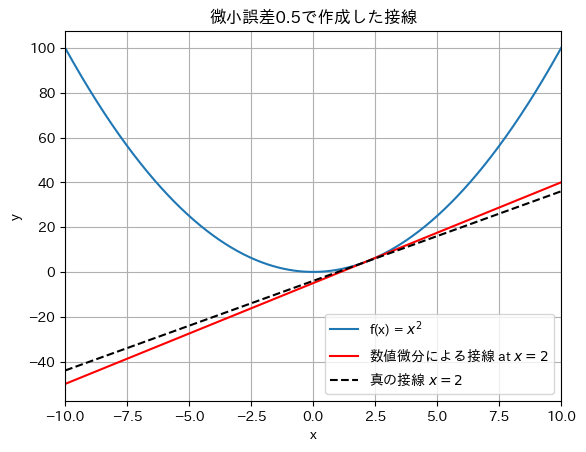

In [100]:
make_figure_of_error_in_numerical_diff(h=0.5,title='微小誤差0.5で作成した接線')

微小誤差が十分に小さくないと，数値微分では記号微分で正しく求められた接線（真の接線）との間にズレが生じるようです．

導関数に用いる微小誤差$h$が十分に小さい場合（$h=0.0001$）を見てみましょう．

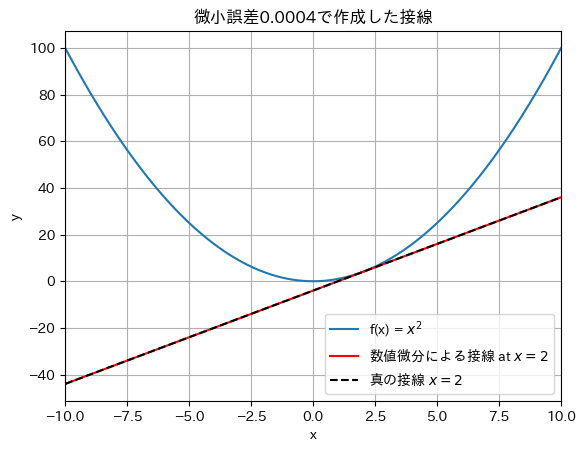

In [101]:
make_figure_of_error_in_numerical_diff(h=1e-4,title='微小誤差0.0001で作成した接線')

グラフ上ではほぼほぼ真の接線と同じ直線になっていることが分かります．かなり高い精度で近似できていることが分かりますね．


ところで，最初の例を思い出してください．$f^{\prime}(x)=(x^2)^{\prime}=2x$の例です．これは6になるはずでした．

In [103]:
numerical_diff(lambda x: x**2, 3, h=1e-4)

6.000100000012054

$h$が十分に小さいとしても，実際に求めた微分の値には，誤差が発生していました．ではどうやってこの誤差を修正すればいいでしょうか．

### 中心差分
丸め誤差のせいで$h$を無限に0に近づけることができないため，数値微分には誤差が含まれます．誤差をできるだけ減らすためには，傾きをとる範囲を$x+h$ から$x$ までの範囲ではなく，$x+h$ から $x-h$ までの範囲で取れば良いのです．そうすればもう少し小さくなるはず．

$$
f^{\prime}(x)=\frac{\mathrm{d} f(x)}{\mathrm{d}x} = \lim_{h\rightarrow 0}\frac{f(x+h)- f(x)}{h} \\
\Longrightarrow f^{\prime}(x)=\frac{\mathrm{d} f(x)}{\mathrm{d}x} = \lim_{h\rightarrow 0}\frac{f(x+h)- f(x-h)}{2h}
$$

これをPythonで実装したのが次のコードです．

:::{margin}
答えを見る前に自分で実装してみよう
:::


In [217]:
def numerical_diff2(f, x, h = 1e-4):
    return (f(x+h) - f(x-h)) / (2*h)

In [218]:
numerical_diff2(lambda x: x**2, 3, h=1e-4)

6.000000000012662

誤差がより小さくなったことが確認できたと思います． 別の問題もやってみましょう．$f(x) = 0.01x^2 + 0.1x $を $x=5，x=10$の場合でそれぞれで微分してみてください．

$$f^{\prime}(x) = 0.02x + 0.1 \\
f^{\prime}(5) = 0.2 \\
f^{\prime}(10) = 0.3 \\
$$

In [7]:
_f = lambda x: 0.01*x**2+0.1*x

print("numerical_diffの場合")

d5 = numerical_diff(_f, x=5)
d10 = numerical_diff(_f, x=10)
print("x=5：", d5, "誤差",0.2-d5)
print("x=10：", d10, "誤差",0.3-d10)


print("numerical_diff2の場合")
d5 = numerical_diff2(_f, x=5)
d10 = numerical_diff2(_f, x=10)
print("x=5：", d5, "誤差",0.2-d5)
print("x=10：", d10, "誤差",0.3-d10)

               

numerical_diffの場合
x=5： 0.20000099999917254 誤差 -9.999991725240243e-07
x=10： 0.3000009999976072 誤差 -9.999976072205818e-07
numerical_diff2の場合
x=5： 0.1999999999990898 誤差 9.102163467389346e-13
x=10： 0.2999999999986347 誤差 1.3652967645327863e-12


微小誤差hを必要以上に大きく設定して，前方差分/中央差分を真の接線と比較してみましょう．

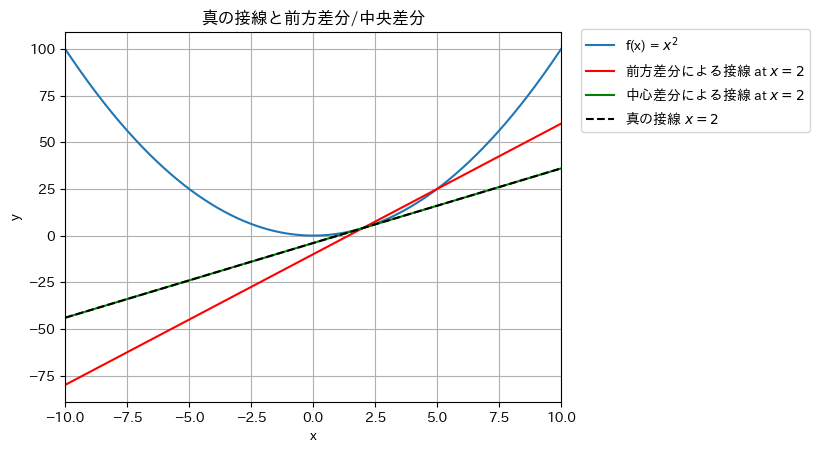

In [77]:
def make_figure_of_error_in_numerical_diff2():
    """make figure of diff between symbolic differentiation and numerical differentiation"""
    # 関数 f(x) = x^2
    def f(x):
        return x**2

    # 接線の傾き（導関数）を求める
    def tangent_slope(x):
        return 2 * x

    # 接線の式
    def tangent_line(x, x0):
        slope = tangent_slope(x0)
        return slope * (x - x0) + f(x0)

    # 数値微分（前方差分）
    def _numerical_diff(f, x, h = 1e-4):
        return (f(x+h) - f(x)) / (h)
    
    # 数値微分（中央差分）
    def _numerical_diff2(f, x, h = 1e-4):
        return (f(x+h) - f(x-h)) / (h*2)

    # 前方差分で求めた接線の式
    def numerical_tangent_line(x, x0, h = 1e-4):
        slope = _numerical_diff(f, x0, h)
        return slope * (x - x0) + f(x0)
    
    # 中央差分で求めた接線の式
    def numerical_tangent_line2(x, x0, h = 1e-4):
        slope = _numerical_diff2(f, x0, h)
        return slope * (x - x0) + f(x0)

    # グラフの範囲
    x_lim=10
    x_vals = np.linspace(-x_lim, x_lim, 1000)
    x0 = 2  # x=3での接線を求める
    h = 3
    # グラフの描画
    fig = plt.figure()

    ax = fig.add_subplot()
    # グラフの範囲
    x_lim=10
    x_vals = np.linspace(-x_lim, x_lim, 1000)
    x0 = 2  # x=3での接線を求める
    h = 3
    ax.plot(x_vals, f(x_vals), label='f(x) = $x^2$')
    ax.plot(x_vals, numerical_tangent_line(x_vals, x0, h), label=f'前方差分による接線 at $x={x0}$', linestyle='-', color="red")
    ax.plot(x_vals, numerical_tangent_line2(x_vals, x0, h), label=f'中心差分による接線 at $x={x0}$', linestyle='-', color="green")
    ax.plot(x_vals, tangent_line(x_vals, x0), label=f'真の接線 $x={x0}$',linestyle='--',  color="black")
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'真の接線と前方差分/中央差分')
    ax.grid(True)
    ax.set_xlim(-x_lim,x_lim)
    fig.legend(bbox_to_anchor=(1.3, 0.9), fontsize=10,)
    plt.close()
    return fig

make_figure_of_error_in_numerical_diff2()

中央差分による接線が真の接線とほぼ同じであることがわかるはずです．

## 偏微分

2変数関数 $f(x_0, x_1) = x_0^2 + x_1^2$ の $x_0=2, x_1=1$ のときの偏微分を考えます．

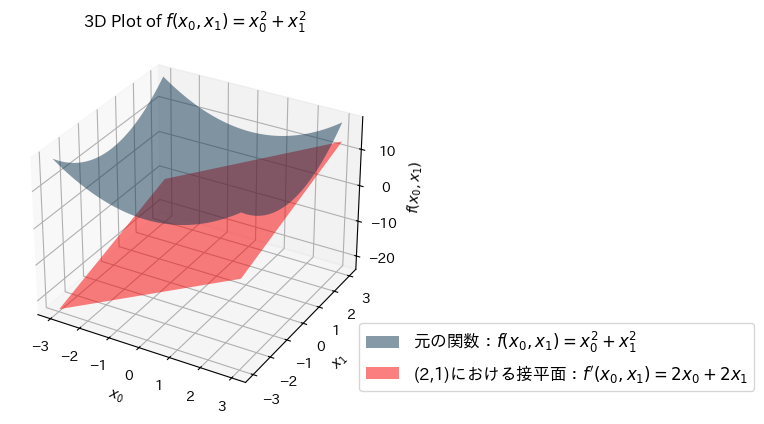

In [116]:
def make_figure_of_bivariate_func_and_tangent_planes():
    # 関数の定義
    def f(x0, x1):
        return x0**2 + x1**2

    # 勾配の定義
    def df(x0, x1):
        return 2*x0, 2*x1

    x0 = 2
    x1 = 1

    x = np.linspace(-3, 3, 100)
    y = np.linspace(-3, 3, 100)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, alpha=0.5, rstride=100, cstride=100, label="元の関数：$f(x_0, x_1) = x_0^2 + x_1^2$")


    # 接平面の描画
    Z_tangent = df(x0, x1)[0]*(X - x0) + df(x0, x1)[1]*(Y - x1) + f(x0, x1)
    ax.plot_surface(X, Y, Z_tangent, alpha=0.5, facecolors='red', rstride=100, cstride=100, linewidth=0, label="(2,1)における接平面：$f^{\prime}(x_0, x_1)= 2x_0 + 2x_1$")

    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$f(x_0, x_1)$')
    ax.set_title('3D Plot of $f(x_0, x_1) = x_0^2 + x_1^2$')
    fig.legend(bbox_to_anchor=(1.4, 0.3), fontsize=12,)
    plt.close()
    return fig

make_figure_of_bivariate_func_and_tangent_planes()


一変数関数の時は「接線」でしたが，今回は線では無く面なので「接平面」と呼びます．

このような関数の偏微分は1 変数の微分と同じで，ある場所の傾きを求めます．ただし，偏微分の場合は複数ある変数の中でターゲットとする変数をひとつに絞り，他の変数はある値に固定します．するとそれぞれの微分値は以下のようになるはずです．

$$
\frac{\partial f}{\partial x_0} = 4, \frac{\partial f}{\partial x_1} = 2
$$

これをプログラムでも確認してみましょう．

In [162]:
# 関数の定義
def f(x0, x1):
    return x0**2 + x1**2


x0 = 2
x1 = 1
d_x0 = numerical_diff2(lambda x0: f(x0, x1), x0) # x1は定数として扱う
d_x1 = numerical_diff2(lambda x1: f(x0, x1), x1) # x0は定数として扱う

print(f"{d_x0=},{d_x1=}" )

d_x0=4.000000000004,d_x1=1.9999999999997797


このようにすれば変数が増えても問題なく微分ができそうです．

## 勾配とは

先ほどの例における任意の点 $(x_0,x_1)$ の両方の偏微分をまとめた$(\frac{\partial f}{\partial x_0}, \frac{\partial f}{\partial x_1} ) $ のように，全ての変数の偏微分をベクトルとしてまとめたものを __勾配 (gradient)__ と呼びます．

これまでの数値微分の関数を使って勾配を求める関数を作成してみます．任意の点の値が配列Xとして渡され，勾配を返す関数は，次のようになります．


:::{margin}
答えを見る前に自分で実装してみよう
:::


In [149]:
def numerical_gradient(f,x, h=1e-4):
    grad = np.zeros_like(x)
    for i in range(x.size):
        # f(x+h)
        x_plus_h = x.copy()
        x_plus_h[i]+=h
        f_x_plus_h = f(x_plus_h)
        
        # f(x-h)
        x_minus_h = x.copy()
        x_minus_h[i]-=h
        f_x_minus_h = f(x_minus_h)

        # (f(x+h) - f(x-h)) / (2*h)
        grad[i] += (f_x_plus_h - f_x_minus_h) / (2*h)
    return grad

この関数は偏微分のところでもあったように，偏微分を行う変数以外を定数として扱う計算によって値を求めています．実際に使ってみましょう．勾配を求める関数は要素数$n$のベクトルのノルムを求める関数$f(x)=\sum_{i=1}^{n}x_i^2$です．

In [160]:
f = lambda x: np.sum(x**2)
x = np.arange(10)
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

この関数の勾配を手計算で求めてから，以下の戻り値が適切か評価してください．

In [161]:
x = x.astype(np.float64)
numerical_gradient(f, x)

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.])

### 小さい数値と浮動小数点数の精度

これまでのプログラムもそうですが，非常に小さい数字を計算に用いる場合は，float型の精度に注意してください．

例えば，上の勾配計算関数 `numerical_gradient` にnp.float64型（倍精度浮動小数点数，double型）のdtypeを持つ配列を入力する場合を見てみましょう．期待通りの答えが得られるはずです．

In [142]:
x = np.arange(10).astype(np.float64)
f = lambda x: np.sum(x**2)
numerical_gradient(f, x)

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.])

次に，`numerical_gradient` にnp.float32型（単精度浮動小数点数，float型）のdtypeを持つ配列を入力する場合を見てみましょう．期待した答えと少し誤差がある値が得られます．

In [153]:
x = x.astype(np.float32)
numerical_gradient(f, x)

array([ 0.       ,  1.8310547,  3.9672852,  6.1035156,  7.9345703,
       10.070801 , 12.207031 , 14.038086 , 15.869141 , 18.005371 ],
      dtype=float32)

どんどん精度を落としていきます．`numerical_gradient` にnp.float16型（半精度浮動小数点数，half型）のdtypeを持つ配列を入力する場合を見てみましょう．精度が落ちすぎて勾配消失が起きました．

In [157]:
x = x.astype(np.float16)
numerical_gradient(f, x)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float16)

最後に，`numerical_gradient` にnp.int64型のdtypeを持つ配列を入力する場合を見てみましょう．分子が大方0になり，分母が非常に小さい数値のままなので，値が爆発してしまいました．

In [156]:
x = x.astype(np.int64)
numerical_gradient(f, x)

array([    0,  5000, 15000, 25000, 35000, 45000, 55000, 65000, 75000,
       85000])

::::{note}
:class: dropdown


通常のDeep Learningの訓練では，[PyTorch](https://pytorch.org/), [TensorFlow](https://www.tensorflow.org/?hl=ja), [JAX](https://jax.readthedocs.io/en/latest/) のようなライブラリを用いて，GPU上で行列計算を行います．そのため，GPUが得意とするfloat32型を用いることが多い筈です．一方で，最近は計算効率を上げるために，float16型との[AMP（Automatic Mixed Precision）](https://developer.nvidia.com/automatic-mixed-precision)を使うことも多々あります．これらのライブラリの自動微分では，ここで解説するシンプルな実装よりも手が込んだ実装になっているはずです．よってもう少し良い値が得られるかもしれませんが，float16型で勾配を求めるとどうなるのかは把握しておいてください．


::::

## 勾配法とは
このノートの先頭に表示していたアニメーションは，まさに勾配法の動作の様子をアニメーション化したものでした．  
![](gradient_descent.gif)

勾配法とは，関数の最小値または最大値を探索する手法です．この中でも特に最小値を探索する勾配法を __勾配降下法__ と呼び，Neural Networkの訓練に用いられています．例えば，適当な（色々なルールに基づいて，ランダムに初期化された）点$x=x_0$から探索を開始して，関数値が減少（小さくなる）方向に向かって繰り返し$x$の値を更新していくのが勾配降下法です．関数値が減少する方向が見つからなくなれば探索を終了させます．

ここで$x$としていた点はスカラーでもベクトルでも行列でも構いません．例えば2要素を持つベクトルを考えましょう．この$x$のような値は，機械学習ではパラメータと呼ばれ，パラメータの更新式は以下の通りです．

$$
\begin{aligned}
& x_0=x_0-\eta \frac{\partial f}{\partial x_0} \\
& x_1=x_1-\eta \frac{\partial f}{\partial x_1}
\end{aligned}
$$

ここで，$\eta$は学習率と呼ばれ，通常は$0<\eta<1$の範囲で定めます．$0.01 \leq \eta \leq 0.001$ 辺りが「とりあえず設定される値」として一般的だと思います．$\eta$はパラメータ更新において普通は __事前に手動で設定__ され，これは移動量を調整するハイパーパラメータとして機能します．接線の傾きの逆方向に移動すると関数の最小値に近づくはずなので，$-\eta \frac{\partial f}{\partial x_0}$のように $-1 \times \text{学習率} \times \text{勾配} $ とされています．

:::{margin}
答えを見る前に自分で実装してみよう
:::


In [168]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    for i in range(step_num):
        grad = numerical_diff(f,x)
        x -= lr * grad
    return x

### 勾配が0になる点

関数値が減少する方向を見つけるために，勾配を参考にしていました．先ほどのパラメータの更新式からも分かるように，$\frac{\partial f}{\partial \mathbf{x}}$の各要素が0ならばパラメータは更新されません．では勾配が$\boldsymbol{0}$になるポイントが関数の最小値なのかというと，そうでもありません．これにはいくつかの場合があります．

#### 極値（極小値，極大値）



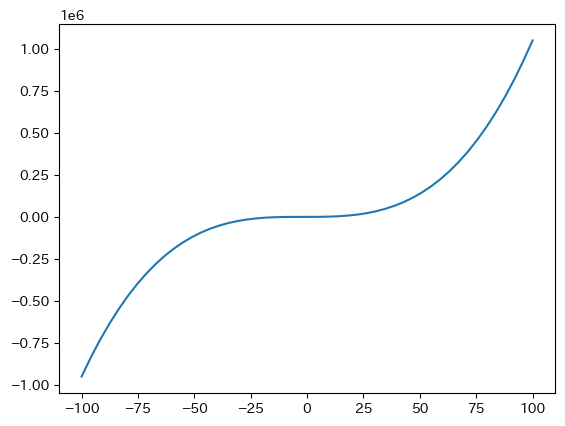

In [220]:
x = np.linspace(-100,100)
f = lambda x: x**3+5*x**2+5*x
plt.plot(x, f(x))


#### 鞍点（あんてん, saddle point）

## 誤差逆伝播法でMLPの学習を効率的に行う

In [204]:
ax.plot?

Signature: ax.plot(*args, scalex=True, scaley=True, data=None, **kwargs)
Docstring:
Plot y versus x as lines and/or markers.

Call signatures::

    plot([x], y, [fmt], *, data=None, **kwargs)
    plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)

The coordinates of the points or line nodes are given by *x*, *y*.

The optional parameter *fmt* is a convenient way for defining basic
formatting like color, marker and linestyle. It's a shortcut string
notation described in the *Notes* section below.

>>> plot(x, y)        # plot x and y using default line style and color
>>> plot(x, y, 'bo')  # plot x and y using blue circle markers
>>> plot(y)           # plot y using x as index array 0..N-1
>>> plot(y, 'r+')     # ditto, but with red plusses

You can use `.Line2D` properties as keyword arguments for more
control on the appearance. Line properties and *fmt* can be mixed.
The following two calls yield identical results:

>>> plot(x, y, 'go--', linewidth=2, markersize=12)
>>> plot(x, y, 